In [42]:
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, "..")

In [90]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [151]:
import json
from tqdm import notebook as tqdm

from sklearn import tree

from program_synthesis.datasets.dataset import KarelTorchDataset
from program_synthesis.datasets.executor import KarelExecutor

In [46]:
data = KarelTorchDataset("../data/karel/train.pkl")

In [7]:
with open("../baseline/nearai32-train.json") as f:
    nearai32_on_train = json.load(f)

In [48]:
assert len(data) == len(nearai32_on_train)

In [49]:
nearai32_on_train[0]

{'output': ['DEF', 'run', 'm(', 'turnLeft', 'move', 'pickMarker', 'm)'],
 'is_correct': True,
 'individual': [1, 1, 1, 1, 1, 1],
 'passes_given_tests': True}

In [20]:
passes_heldout = np.array([bool(d['individual'][-1]) for d in nearai32_on_train])
passes_given = np.array([all(d['individual'][:-1]) for d in nearai32_on_train])

In [24]:
print("Correct            : %10.4f%%" % (100 * np.mean(passes_given & passes_heldout)))
print("Overfit            : %10.4f%%" % (100 * np.mean(passes_given & ~passes_heldout)))
print("Only Passes Heldout: %10.4f%%" % (100 * np.mean(~passes_given & passes_heldout)))
print("Fully Wrong        : %10.4f%%" % (100 * np.mean(~passes_given & ~passes_heldout)))

Correct            :    85.0722%
Overfit            :     4.1235%
Only Passes Heldout:     0.0000%
Fully Wrong        :    10.8043%


In [31]:
corrects = [d for d in nearai32_on_train if d['is_correct']]
overfits = [d for d in nearai32_on_train if not d['is_correct'] and d['passes_given_tests']]

In [32]:
np.sum(passes_given & ~passes_heldout), len(overfits)

(46054, 46054)

In [152]:
lengths = np.array([len(d['output']) for d in nearai32_on_train])

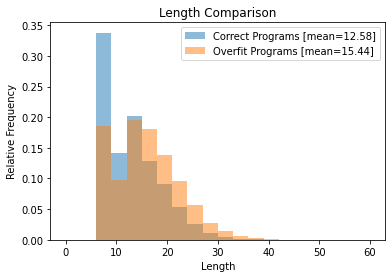

In [40]:
c_lengths = [len(d['output']) for d in corrects]
o_lengths = [len(d['output']) for d in overfits]
plt.hist(c_lengths, alpha=0.5,
         label="Correct Programs [mean=%.2f]" % np.mean(c_lengths),
         weights=np.ones_like(c_lengths)/len(c_lengths),
         bins=np.linspace(0, 60, 21))
plt.hist(o_lengths, alpha=0.5,
         label="Overfit Programs [mean=%.2f]" % np.mean(o_lengths),
         weights=np.ones_like(o_lengths)/len(o_lengths),
         bins=np.linspace(0, 60, 21))
plt.xlabel("Length")
plt.ylabel("Relative Frequency")
plt.title("Length Comparison")
plt.legend()
plt.show()

In [137]:
with open("../coverages/nearai32-train.json") as f:
    coverages = json.load(f)

In [138]:
assert len(coverages) == len(data)

In [143]:
def action_cover_counts(coverage):
    if coverage is None:
        return np.array([0])
    are_actions = np.array(coverage['classification']['action'], dtype=np.bool)
    by_action = np.zeros(len(are_actions), dtype=np.int)
    for test in coverage['coverage']:
        by_action += test['action']
    return by_action[are_actions]
def branch_cover_counts(coverage):
    if coverage is None:
        return np.array([0])
    are_branches = np.array(coverage['classification']['branch'], dtype=np.bool)
    by_branch = np.zeros(len(are_branches), dtype=np.int)
    for test in coverage['coverage']:
        by_branch += np.all(test['branch'], axis=1)
    return by_branch[are_branches]

In [144]:
data[3].code_sequence

['DEF',
 'run',
 'm(',
 'pickMarker',
 'REPEAT',
 'R=7',
 'r(',
 'move',
 'putMarker',
 'r)',
 'move',
 'turnRight',
 'm)']

In [145]:
full_action_coverage = np.array([(action_cover_counts(coverage) >= 1).all() for coverage in coverages])
double_action_coverage = np.array([(action_cover_counts(coverage) >= 2).all() for coverage in coverages])
full_branch_coverage = np.array([(branch_cover_counts(coverage) >= 1).all() for coverage in coverages])
double_branch_coverage = np.array([(branch_cover_counts(coverage) >= 2).all() for coverage in coverages])

In [146]:
def three_statistics(mask):
    overall = np.mean(mask & passes_given) / np.mean(passes_given)
    among_correct = np.mean(mask & passes_given & passes_heldout) / np.mean(passes_given & passes_heldout)
    among_overfit = np.mean(mask & passes_given & ~passes_heldout) / np.mean(passes_given & ~passes_heldout)
    return overall, among_correct, among_overfit

In [147]:
three_statistics(full_action_coverage)

(0.9756601678802954, 0.9779325398997193, 0.9287792591305857)

In [148]:
three_statistics(double_action_coverage)

(0.8854972866512879, 0.8915961150661171, 0.7596734268467451)

In [149]:
three_statistics(full_branch_coverage)

(0.8372522801966701, 0.8424808342419791, 0.7293828983367351)

In [150]:
three_statistics(double_branch_coverage)

(0.8062450185005612, 0.8127575957866907, 0.6718851782689885)

In [153]:
stats = np.array([
    lengths,
    full_action_coverage,
    double_action_coverage,
    full_branch_coverage,
    double_branch_coverage
])

In [177]:
overfit_idx = np.where(passes_given & ~passes_heldout)[0]
correct_idx = np.where(passes_given &  passes_heldout)[0]
minima = min(overfit_idx.size, correct_idx.size)
all_idx = np.concatenate([overfit_idx[:minima], correct_idx[:minima]])

In [178]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(stats.T[all_idx], passes_heldout[all_idx])

In [179]:
def confusion(ypred, y):
    return ([[np.mean((ypred == i) & (y == j)) * 100 for i in range(2)] for j in range(2)])

In [183]:
np.mean(clf.predict(stats.T[all_idx]))

0.4773092456681287

In [184]:
confusion(clf.predict(stats.T[all_idx]), passes_heldout[all_idx])

[[31.671516046380336, 18.328483953619664],
 [20.59755938680679, 29.40244061319321]]